In [8]:
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.palettes import Colorblind
output_notebook()

import numpy as np
import pandas as pd
import astropy.units as u
import virga.justdoit as jdi
import virga.justplotit as jpi
import matplotlib.pyplot as plt
import time
from bokeh.plotting import show, figure
from bokeh.layouts import column

Loading BokehJS ...

In [13]:
# locate mieff files
mieff_directory = "~/Documents/codes/all-data/mieff_files"

# temperature-pressure profiles
TP_directory = "~/Documents/codes/all-data/Mark_data/"
filenames = ["t1000g1000nc_m0.0.dat", "t1500g1000nc_m0.0.dat", "t1700g1000f3_m0.0k.dat", \
                    "t200g3160nc_m0.0.dat", "t2400g3160nc_m0.0.dat"]
filename = TP_directory + filenames[1]
    
#   define atmosphere properties
df = pd.read_csv(filename, delim_whitespace=True, usecols=[1,2], header=None)
df.columns = ["pressure", "temperature"]
pressure = np.array(df["pressure"])[1:]
temperature = np.array(df["temperature"])[1:]
grav = df["pressure"][0] * 100 
kz = 1e9
fsed = .1
    
metallicity = 1 # atmospheric metallicity relative to Solar
mean_molecular_weight = 2.2 # atmospheric mean molecular weight
# get pyeddy recommendation for which gases to run
recommended_gases = jdi.recommend_gas(pressure, temperature, metallicity, mean_molecular_weight)
# using one gas for demonstration
gas = [recommended_gases[0]]

a = jdi.Atmosphere(gas, fsed=fsed, mh=metallicity, mmw=mean_molecular_weight)
a.gravity(gravity=grav, gravity_unit=u.Unit('cm/(s**2)'))
a.ptk(df = pd.DataFrame({'pressure':pressure, 'temperature':temperature,
                                   'kz':kz}))


eddysed qc_path =  [0.00971497]
new solver qc_path =  [0.00966537]


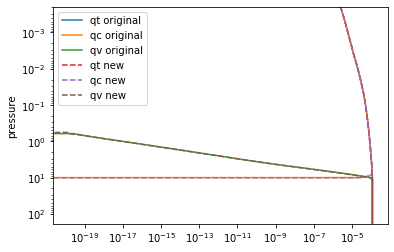

In [14]:
#   verify original and new solvers give same mixing ratios
labels = ["original", "new"]
lines = ["-", "--"]
solver = [True, False] # True = pyeddy, False = new sover
# boolean for new solver -- when true, refines temperature-pressure profile for altitude generation
refine_TP = True
# boolean to stop code after mmr calculated -- useful for this test
quick_stop = True
output = []
for i in range(2):
    all_out = jdi.compute(a, as_dict=True, directory=mieff_directory, layers=solver[i], refine_TP=refine_TP, 
            quick_stop=quick_stop)
    output.append(all_out)
    pres = all_out['pressure']
    qt = all_out['cond_plus_gas_mmr'][:,0]
    qc = all_out['condensate_mmr'][:,0]

    plt.loglog(qt, pres, lines[i], label="qt " + labels[i] )
    plt.loglog(qc, pres, lines[i], label="qc " + labels[i] )
    plt.loglog(qt-qc, pres, lines[i], label="qv " + labels[i] )

pres = output[0]["pressure"]
qc = output[0]["condensate_mmr"][:,0]
plt.ylim(pres[len(pres)-1], pres[0])
#ax1.set_xlim([np.max([1e-9, np.min(qc*0.9)]), np.max(qc*1.1)])
plt.ylabel("pressure")
plt.legend(loc="best")
plt.show()


In [15]:
from bokeh.palettes import viridis,magma
from bokeh.models import ColumnDataSource, Label, LabelSet,CustomJS
from bokeh.layouts import column,row
from bokeh.plotting import figure, show
from bokeh.models import LinearColorMapper, LogTicker,BasicTicker, ColorBar,LogColorMapper,Legend
from bokeh.palettes import magma as colfun1
from bokeh.palettes import viridis as colfun2
from bokeh.palettes import gray as colfun3

def condensate_mmr(output, color = magma, **kwargs):
    kwargs['plot_height'] = kwargs.get('plot_height',300)
    kwargs['plot_width'] = kwargs.get('plot_width',400)
    kwargs['x_axis_label'] = kwargs.get('x_axis_label','Condensate MMR')
    kwargs['y_axis_label'] = kwargs.get('y_axis_label','Pressure (bars)')
    kwargs['y_axis_type'] = kwargs.get('y_axis_type','log')
    kwargs['x_axis_type'] = kwargs.get('x_axis_type','log')    

    pressure = output[0]['pressure']
    cond_mmr = output[0]['condensate_mmr']

    kwargs['y_range'] = kwargs.get('y_range',[np.max(pressure), np.min(pressure)])
    kwargs['x_range'] = kwargs.get('x_range',[np.max([1e-9, np.min(cond_mmr*0.9)]), 
                                            np.max(cond_mmr*1.1)])
    fig = figure(**kwargs)
    col = color(4)
    lines = ["solid","dashed"]
    for i in range(2):
        pressure = output[i]['pressure']
        cond_mmr = output[i]['condensate_mmr'][:,0]
        fig.line(cond_mmr, pressure, line_width=4, line_dash=lines[i], legend_label = labels[i], color=col[2*i])
    
    jpi.plot_format(fig)
    return fig


In [16]:
show(condensate_mmr(output))